df_encoded ready: shape (46, 95)
PCA complete: projected data shape (46, 2)


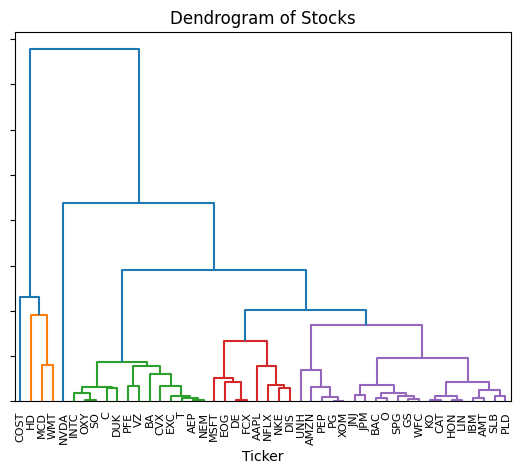

In [2]:
import pandas as pd
import setup

df_results = pd.read_csv("df_results.csv")

# Remove stocks with insufficient historical data for backtesting
df_results = df_results[~df_results["ticker"].isin(["DOW", "MRNA", "ABBV", "TSLA"])]

df_results = setup.compute_composite_metrics(df_results)
df_encoded = setup.setup_data(df_results)

pca_cols = ["profitability", "liquidity", "efficiency", "market_value", "leverage"]
projectedData, pca_model = setup.perform_pca(df_encoded, columns=pca_cols, n_components=2)

df_results = setup.compute_clusters(df_results, projectedData, method="dendrogram", n_clusters=5)

In [3]:
df_results = setup.compute_clusters(df_results, projectedData, method="kmeans", n_clusters=3)

df_results[df_results["ticker"].isin(["AAPL", "MSFT"])][["ticker"] + pca_cols]

,ticker,profitability,liquidity,efficiency,market_value,leverage
0,AAPL,1.976935,-0.341527,2.105240,2.197644,1.027773
3,MSFT,1.883232,1.201107,0.143427,1.331835,0.390123


In [4]:
from sklearn.cluster import KMeans

df_PCA = pd.DataFrame(projectedData, columns=['prin_comp_1','prin_comp_2'])
model = KMeans(n_clusters = 5, random_state=42)
cluster_labels = model.fit_predict(df_PCA)

# Assign cluster labels
df_results['cluster'] = cluster_labels
df_PCA['cluster'] = cluster_labels

<Axes: xlabel='prin_comp_1', ylabel='prin_comp_2'>

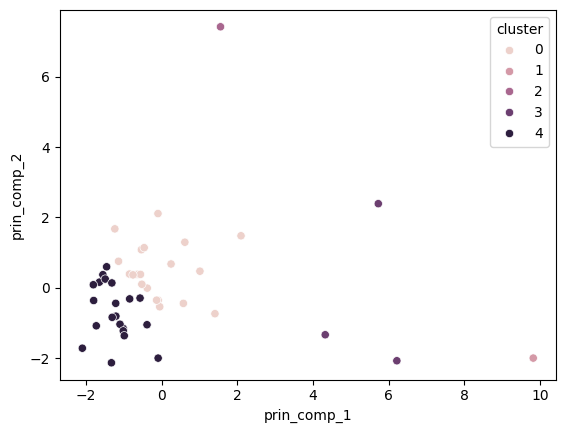

In [5]:
import seaborn as sns

sns.scatterplot(data=df_PCA, x='prin_comp_1', y='prin_comp_2', hue='cluster')

### Basic Models Setup

In [26]:
import numpy as np

# 1: Randomly sample stocks
random_portfolio = df_results["ticker"].sample(15, random_state=42)

# 2: Randomly sample from each industry
industry_grouped_portfolio = df_results.groupby('Industry').apply(lambda x: x.sample(1, random_state=42)).reset_index(drop=True)

/var/folders/rs/dqcm8rm967g9vzgwrpdplf080000gn/T/ipykernel_93025/2256278156.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  industry_grouped_portfolio = df_results.groupby('Industry').apply(lambda x: x.sample(1, random_state=42)).reset_index(drop=True)


In [13]:
df_results.head()

,net_profit_margin,gross_profit_margin,roa,roe,current_ratio,quick_ratio,cash_ratio,inventory_turnover,accounts_receivable_turnover,asset_turnover,...,ticker,elapsed,Industry,profitability,liquidity,efficiency,market_value,leverage,cluster,earliest
0,0.253062,0.441311,0.275098,1.560760,0.988012,0.944442,0.206217,37.977654,13.287284,1.087077,...,AAPL,6.176377,Consumer Electronics,1.976935,-0.341527,2.105240,2.197644,1.027773,0,1981-01-01
3,0.341462,0.689201,0.175644,0.350887,1.769167,1.745163,0.333215,21.103172,4.559812,0.514387,...,MSFT,9.992679,Software,1.883232,1.201107,0.143427,1.331835,0.390123,0,1986-04-01
4,0.161934,0.569289,0.106066,0.197638,3.515618,2.729544,0.516380,2.992787,6.364044,0.654995,...,NVDA,10.328692,Semiconductors,0.529821,3.749290,-0.102903,7.434488,-0.568840,2,1999-02-01
5,0.035582,0.580978,0.009355,0.023805,0.906662,0.693476,0.059694,2.603443,5.289369,0.262926,...,PFE,13.567713,Pharmaceuticals,-0.532759,-0.893948,-0.813460,-1.553356,-0.578217,4,1984-12-01
6,0.060225,0.244759,0.081766,0.252163,0.791861,NaN,0.256698,NaN,19.078574,1.357672,...,UNH,13.615499,Healthcare Services,-0.652391,-0.383369,2.147648,0.547571,-0.213943,0,1984-12-01


In [6]:
df_results["ticker"]

0     AAPL
3     MSFT
4     NVDA
5      PFE
6      UNH
7     INTC
8      JNJ
9      JPM
10     IBM
11     BAC
12      GS
13       C
14     WFC
15     MCD
17      HD
18    AMZN
19     NKE
20      PG
21      KO
22     WMT
23    COST
24     PEP
25     XOM
26     CVX
27     SLB
28     EOG
29     OXY
30     CAT
31      BA
32      DE
33     HON
34     DUK
35      SO
36     AEP
38     EXC
39     FCX
40     LIN
41     NEM
42    NFLX
43     DIS
44      VZ
45       T
46       O
47     PLD
48     AMT
49     SPG
Name: ticker, dtype: object

### Check Earliest Stock Dates

In [ ]:
import okama as ok
from tqdm import tqdm

all_assets = ok.AssetList([ticker + ".US" for ticker in df_results["ticker"]])

earliest = {}
for ticker in all_assets:
    earliest[ticker] = ticker.first_date

100%|██████████| 46/46 [01:32<00:00,  2.01s/it]


In [8]:
df_results["earliest"] = df_results["ticker"].map(earliest)

In [35]:
df_results.sort_values(by = "earliest", inplace = True, ascending = False)
df_results[["ticker", "earliest"]].head()

,ticker,earliest
37,DOW,2019-04-01
2,MRNA,2019-01-01
1,ABBV,2013-01-01
16,TSLA,2010-07-01
42,NFLX,2002-06-01


### Check Historical Stock Volatility/Return

In [8]:
import okama as ok
all_assets = ok.AssetList([ticker + ".US" for ticker in df_results["ticker"]])

In [9]:
# Calculate the rolling annual risk for each asset
rolling_risks = all_assets.get_rolling_risk_annual()

risks = {}

# Calculate the average rolling risk for each asset
for asset in all_assets:
    risks[asset.ticker] = rolling_risks[asset.ticker + ".US"][0]

# Map the calculated risks to the "ticker" column in df_results
df_results["risk"] = df_results["ticker"].map(risks)

/var/folders/rs/dqcm8rm967g9vzgwrpdplf080000gn/T/ipykernel_93025/365516123.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  risks[asset.ticker] = rolling_risks[asset.ticker + ".US"][0]


In [ ]:
# # Write to CSV
# df_results.to_csv("df_results.csv", index=False)

#### AMT and Risk Exploration Sidebar

In [52]:
stock = ok.Asset("AMT.US")

In [ ]:
# Explore this weird result
df_results.sort_values(by = "risk", inplace = True, ascending = False)
df_results[["ticker", "risk"]].head()

,ticker,risk
48,AMT,20.437652
4,NVDA,3.059320
18,AMZN,1.085627
42,NFLX,0.957420
9,JPM,0.678396


[(0.0, 1.5)]

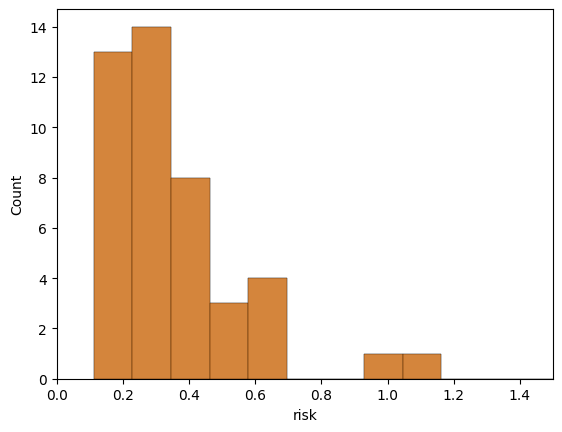

In [ ]:
import seaborn as sns

sns.histplot(df_results["risk"]).set(xlim=(0, 1.5))

<Axes: xlabel='risk', ylabel='Count'>

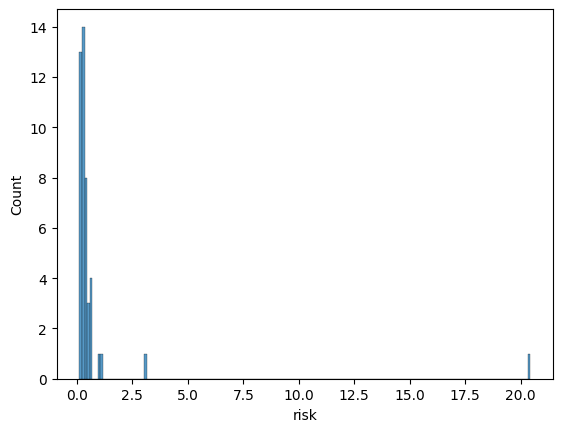

In [64]:
sns.histplot(df_results["risk"])

### Strategy 1: Random Sampling From Clusters

In [108]:
base_portfolio = df_results.groupby('cluster').apply(lambda x: x.sample(1)).reset_index(drop=True)

/var/folders/rs/dqcm8rm967g9vzgwrpdplf080000gn/T/ipykernel_34729/55610728.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  base_portfolio = df_results.groupby('cluster').apply(lambda x: x.sample(1)).reset_index(drop=True)


### Strategy 2: Historical Risk Based Model (without clusters)

In [ ]:
low_risk_portfolio = df_results[df_results["risk"] < df_results["risk"].quantile(0.25)].sample(10, random_state=42) # TODO: Rerun

med_risk_portfolio = df_results[(df_results["risk"] >= df_results["risk"].quantile(0.25)) & (df_results["risk"] < df_results["risk"].quantile(0.75))].sample(10, random_state=42)

high_risk_portfolio = df_results[df_results["risk"] >= df_results["risk"].quantile(0.75)].sample(10, random_state=42)

##

## Evaluate Models 

### Setup Portfolio and Evaluation Function

In [16]:
import okama as ok

# tickers = list(base_portfolio["ticker"])
# tickers = list(low_risk_portfolio["ticker"])
# tickers = list(med_risk_portfolio["ticker"])
# tickers = list(high_risk_portfolio["ticker"])
# tickers = list(random_portfolio)
tickers = list(df_results["ticker"])

tickers_with_ext = [f"{ticker}.US" for ticker in tickers]


assets = tickers_with_ext
weights = [1/len(tickers)] * len(tickers)

pf = ok.Portfolio(
    assets=assets,
    weights=weights,    
    ccy='USD',
    rebalancing_period='month',  # 'Q' for quarterly, 'A' for annual, etc.
    first_date='2004-01',    # pick a reasonable start date (earliest is 2003-09 from initial assessment)
    last_date='2024-02'       # pick an end date to evaluate
)

In [29]:
def update_weights(tickers, pf):
    tickers_with_ext = [f"{ticker}.US" for ticker in tickers]
    weight = 1/len(tickers)
    for key in pf.assets_weights.keys():
        pf.assets_weights[key] = 0
        if key in tickers_with_ext:
            pf.assets_weights[key] = weight    

In [33]:
def extract_return(wealth_index, start_date, end_date):
    # Overall return
    start_val = wealth_index.loc[start_date, wealth_index.columns[0]]
    end_val   = wealth_index.loc[end_date, wealth_index.columns[0]]
    overall = end_val / start_val - 1
    
    # Annualized return
    sd = pd.to_datetime(start_date)
    ed = pd.to_datetime(end_date)
    years = (ed - sd).days / 365.25
    annual = (end_val / start_val) ** (1/years) - 1
    
    # Year-on-year returns
    yoy = {}
    for year in range(int(start_date[:4]), int(end_date[:4])):
        d1 = f"{year}-12"
        d2 = f"{year+1}-12"
        try:
            ret = wealth_index.loc[d2, wealth_index.columns[0]] / wealth_index.loc[d1, wealth_index.columns[0]] - 1
        except Exception:
            ret = None
        yoy[f"{year}-{year+1}"] = ret
    return overall, annual, yoy

start_date = "2021-12"
end_date   = "2024-02"

overall_ret, ann_ret, yoy_returns = extract_return(pf.wealth_index, start_date, end_date)

print(f"Period: {start_date} to {end_date}")
print(f"Overall Return: {overall_ret * 100:.2f}%")
print(f"Annualized Return: {ann_ret * 100:.2f}%")
print("Year-on-Year Returns:", yoy_returns)

Period: 2021-12 to 2024-02
Overall Return: 18.25%
Annualized Return: 8.04%
Year-on-Year Returns: {'2021-2022': np.float64(0.060026891866880705), '2022-2023': np.float64(0.06717276563771013), '2023-2024': None}


### Bootstrapped Sample of Years

In [ ]:
NUMBER_OF_BOOTSTRAPPED_SAMPLES = 50
YEARS_OF_SAMPLE = 5

results = []

for i in range(NUMBER_OF_BOOTSTRAPPED_SAMPLES):
    
    random_portfolio = df_results["ticker"].sample(15, random_state=i)

    tickers = 
    update_weights(tickers, pf)

    # Randomly select a 12 month period in the range 2004-01 to 2023-01
    END_DATE = 2023 # 
    DATE_RANGE_END = END_DATE - YEARS_OF_SAMPLE
    start_date = f"{np.random.randint(2004, DATE_RANGE_END):04d}-{np.random.randint(1, 13):02d}"
    end_date   = f"{int(start_date[:4])+YEARS_OF_SAMPLE:04d}-{start_date[5:]}"

    overall_ret, ann_ret, yoy_returns = extract_return(pf.wealth_index, start_date, end_date)
    
    # Store results
    results.append({
        "start_date": start_date,
        "end_date": end_date,
        "start_value": pf.wealth_index.loc[start_date, pf.wealth_index.columns[0]],
        "end_value": pf.wealth_index.loc[end_date, pf.wealth_index.columns[0]],
        "overall_ret": overall_ret,
        "ann_ret": ann_ret,
        "yoy_returns": yoy_returns
    })


In [149]:
from tools import save_portfolio_results, retrieve_portfolio_results

save_portfolio_results(portfolio_name="base_portfolio", results=results, simulation="bootstrap")


Results for portfolio 'base_portfolio' saved to ../data/bootstrap_results.json


In [150]:
res = retrieve_portfolio_results("base_portfolio")

In [151]:
# Extract average end value
ovr_rets = [result["overall_ret"] for result in res]
ovr_rets = pd.Series(ovr_rets)
print(f"Mean Return: {round(10000 * (1 + ovr_rets.mean()), 2):>15}")
print(f"Standard Deviation: {round(10000 * ovr_rets.std(), 2):>7}")

Mean Return:        21550.62
Standard Deviation: 5915.88


In [92]:
# Average annual returns
ann_rets = [result["ann_ret"] for result in res]
mean_ann_ret = np.mean(ann_rets)
std_ann_ret = np.std(ann_rets)

print(f"Average Yearly Return: {round(mean_ann_ret * 100, 2):>20}%", sep = "")
print("Standard Deviation of Yearly Returns: ", round(std_ann_ret * 100, 2), "%", sep = "")

Average Yearly Return:                13.18%
Standard Deviation of Yearly Returns: 3.22%


### Monte Carlo Simulation

In [13]:
SAMPLE_SIZE = 15

# Standardize random portfolio
random_portfolio = df_results.sample(SAMPLE_SIZE, random_state=42)

# Standardize industry_grouped_portfolio
industry_counts = df_results['Industry'].value_counts()
selected_industries = industry_counts.sample(min(11, SAMPLE_SIZE), random_state=42).index.tolist()
industry_grouped_portfolio = df_results[df_results['Industry'].isin(selected_industries)].groupby('Industry').apply(
    lambda x: x.sample(1, random_state=42)
).reset_index(drop=True)

# Add 4 additional stocks from industries with more stocks
additional_industries = industry_counts[~industry_counts.index.isin(selected_industries)].sample(max(0, SAMPLE_SIZE - 11), random_state=42).index.tolist()
additional_stocks = df_results[df_results['Industry'].isin(additional_industries)].groupby('Industry').apply(
    lambda x: x.sample(1, random_state=42)
).reset_index(drop=True)

industry_grouped_portfolio = pd.concat([industry_grouped_portfolio, additional_stocks]).reset_index(drop=True)

# Standardize base_portfolio
base_portfolio = df_results.groupby('cluster').apply(
    lambda x: x.sample(min(len(x), 3), random_state=42)
).reset_index(drop=True)

# If fewer than 15 stocks, sample additional stocks from other clusters
if len(base_portfolio) < SAMPLE_SIZE:
    additional_stocks = df_results[~df_results['ticker'].isin(base_portfolio['ticker'])].sample(
        SAMPLE_SIZE - len(base_portfolio), random_state=42
    )
    base_portfolio = pd.concat([base_portfolio, additional_stocks]).reset_index(drop=True)

# Standardize low-risk portfolio
low_risk_portfolio = df_results[df_results["risk"] < df_results["risk"].quantile(0.33)].sample(SAMPLE_SIZE, random_state=42)

# Standardize medium-risk portfolio # FIXME: Not enough stocks to sample 15 
med_df = df_results[
    (df_results["risk"] >= df_results["risk"].quantile(0.34)) & 
    (df_results["risk"] < df_results["risk"].quantile(0.66))
]
med_risk_portfolio = med_df.sample(min(SAMPLE_SIZE, len(med_df)), random_state=42)

# Standardize high-risk portfolio
high_risk_portfolio = df_results[df_results["risk"] >= df_results["risk"].quantile(0.67)].sample(SAMPLE_SIZE, random_state=42)

/var/folders/rs/dqcm8rm967g9vzgwrpdplf080000gn/T/ipykernel_93025/880330465.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  industry_grouped_portfolio = df_results[df_results['Industry'].isin(selected_industries)].groupby('Industry').apply(
/var/folders/rs/dqcm8rm967g9vzgwrpdplf080000gn/T/ipykernel_93025/880330465.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  additional_stocks = df_results[df_resu

In [14]:
import okama as ok

# Options: random_portfolio, industry_grouped_portfolio, base_portfolio, low_risk_portfolio, med_risk_portfolio, high_risk_portfolio

portfolio_choice = random_portfolio

tickers_with_ext = [f"{ticker}.US" for ticker in list(portfolio_choice["ticker"])]

assets = tickers_with_ext
weights = [1/len(assets)] * len(assets) # Equal weights

pf = ok.Portfolio(
    assets=assets,
    weights=weights,    
    ccy='USD',
    rebalancing_period='month',  # 'Q' for quarterly, 'A' for annual, etc.
    first_date='2004-01',    # pick a reasonable start date (earliest is 2003-09 from initial assessment)
    last_date='2024-02'       # pick an end date to evaluate
)

In [212]:
df_results[["ticker", "cluster"]][df_results["cluster"] == 2]

,ticker,cluster
4,NVDA,2


In [200]:
wealth = pf.monte_carlo_wealth(distr='norm', years=5, n=1000)

# Take the last row as the 1 year return
returns_y = wealth.iloc[-1, 0:]

returns = returns_y

In [145]:
# import tools
from tools import save_portfolio_results, retrieve_portfolio_results

save_portfolio_results(portfolio_name="base_portfolio", results=returns_y, simulation="monte_carlo")
returns = retrieve_portfolio_results("base_portfolio", simulation="monte_carlo")

Results for portfolio 'base_portfolio' saved to ../data/monte_carlo_results.json


In [201]:
print("Average end value: $", round(returns.mean(), 2), sep = "")
print("Standard Deviation: $", round(returns.std(), 2), sep = "")
# print("Average Return: ", round(((returns.mean() / 10000) - 1) * 100, 2), "%", sep = "")
# print(round(((returns.std()) - 1) * 100, 2), "%", sep = "")

Average end value: $22419.26
Standard Deviation: $7959.62


<Axes: xlabel='2029-01', ylabel='Count'>

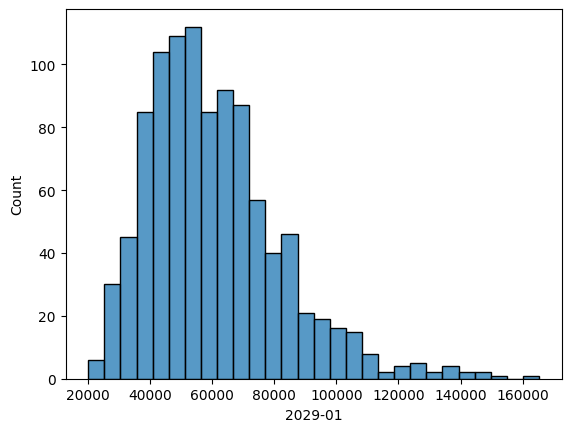

In [147]:
sns.histplot(returns_y)

### Scenario Analysis

In [73]:
import pandas as pd

# Define the contingency periods in a dictionary: (start_date, end_date)
contingencies = {
    "Housing Bust": ("2007-12", "2009-03"),
    "Covid Bust": ("2020-01", "2020-04"),
    "Decade Boom": ("2009-03", "2019-12"),
    "Covid Boom": ("2020-04", "2024-02"),
    "Two Decades": ("2004-02", "2024-02")
}

# Loop through each contingency, calculate returns, and store in a list of dictionaries
results = []
for label, (start_date, end_date) in contingencies.items():
    overall, annual, _ = extract_return(pf.wealth_index, start_date, end_date)
    results.append({
        "Contingency": label,
        "Period": f"{start_date} to {end_date}",
        "Overall Return (%)": round(overall * 100, 1),
        "Annual Return (%)": round(annual * 100, 1)
    })

# Create a DataFrame and nicely display it
df_returns = pd.DataFrame(results).set_index("Contingency")
display(df_returns)

,Period,Overall Return (%),Annual Return (%)
Contingency,,,
Housing Bust,2007-12 to 2009-03,-40.6,-34.1
Covid Bust,2020-01 to 2020-04,-14.1,-45.7
Decade Boom,2009-03 to 2019-12,808.3,22.8
Covid Boom,2020-04 to 2024-02,222.0,35.6
Two Decades,2004-02 to 2024-02,2695.7,18.1


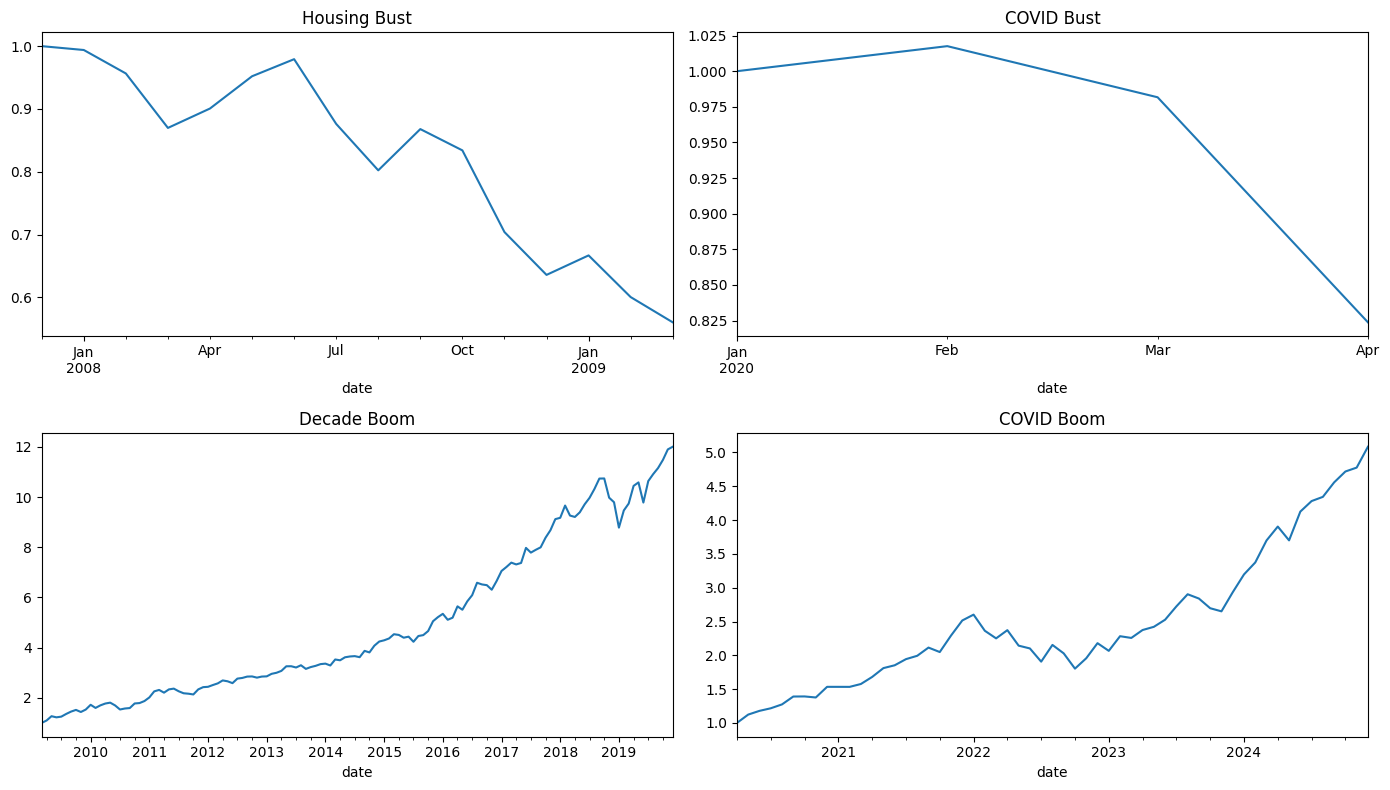

In [52]:
import matplotlib.pyplot as plt

contingencies = {
    "Housing Bust": ("2007-12", "2009-03"),
    "COVID Bust": ("2020-01", "2020-04"),
    "Decade Boom": ("2009-03", "2019-12"),
    "COVID Boom": ("2020-04", "2024-12")
}

fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.flatten()  # Easier indexing of axes

for ax, (name, (start, end)) in zip(axes, contingencies.items()):
    wealth_index = pf.wealth_index[pf.wealth_index.columns[0]] / pf.wealth_index.loc[start, pf.wealth_index.columns[0]]
    wealth_period = wealth_index.loc[start:end]

    wealth_period.plot(ax=ax, title=name, xlim=[start, end])

    # Dynamically adjust ylim
    data_min, data_max = wealth_period.min(), wealth_period.max()
    padding = (data_max - data_min) * 0.05
    ax.set_ylim(data_min - padding, data_max + padding)

plt.tight_layout()
plt.show()

### Recent Year Evaluation

In [10]:
import okama as ok

# tickers = list(df_results["ticker"])

tickers = list(base_portfolio["ticker"])

tickers_with_ext = [f"{ticker}.US" for ticker in tickers]


assets = tickers_with_ext
weights = [1/len(tickers)] * len(tickers)

pf = ok.Portfolio(
    assets=assets,
    weights=weights,    
    ccy='USD',
    rebalancing_period='month',  # 'Q' for quarterly, 'A' for annual, etc.
    first_date='2021-12',    # pick a reasonable start date (earliest is 2003-09 from initial assessment)
    last_date='2024-12'       # pick an end date to evaluate
)

In [11]:
def extract_return(wealth_index, start_date, end_date):
    return wealth_index.loc[end_date, wealth_index.columns[0]] / wealth_index.loc[start_date, wealth_index.columns[0]] - 1

start_date = "2021-12"
end_date = "2024-12"

ret = extract_return(pf.wealth_index, start_date, end_date)

print(f"Start date: {start_date}")
print(f"End date: {end_date}")
# print(f"Years: {end_date - start_date}")
print(f"Return: {ret * 100:.2f}%")
# Annualized return

# TODO: Show the year on year returns

Start date: 2021-12
End date: 2024-12
Return: 81.82%
